In [64]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_repo_data, split_data
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from acquire import get_df

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import varname
import nltk

from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


import warnings
warnings.filterwarnings("ignore")

### TEST CELLS FOR MODULE CREATION

In [126]:
# function to get repo_names for acquire

def get_repo_names():
    repo_names = []

    for page in range(20,30):
        print(f'Scraping page {page}...')
        link = f'https://github.com/search?p={page}&q=zombie&type=Repositories'
        print(f'Address: {link}')
        response = requests.get(link, headers={'user-agent': 'Codeup DS Hopper'})
        soup = BeautifulSoup(response.text)
        print(f"First repository on page... {soup.find_all('a',class_='v-align-middle')[0]['href']}")
        time.sleep(5)
        for repository in range(0,len(soup.find_all('a',class_='v-align-middle'))):
            repo_names.append(soup.find_all('a', class_='v-align-middle')[repository]['href'])
    time.sleep(10)

    for page in range(30,40):
        print(f'Scraping page {page}...')
        link = f'https://github.com/search?p={page}&q=zombie&type=Repositories'
        print(f'Address: {link}')
        response = requests.get(link, headers={'user-agent': 'Codeup DS Hopper'})
        soup = BeautifulSoup(response.text)
        print(f"First repository on page... {soup.find_all('a',class_='v-align-middle')[0]['href']}")
        time.sleep(5)
        for repository in range(0,len(soup.find_all('a',class_='v-align-middle'))):
            repo_names.append(soup.find_all('a', class_='v-align-middle')[repository]['href'])
    return repo_names

In [66]:
# repo_names = get_repo_names()
# repo_names


In [67]:
# read data.json into dataframe... add to acquire.py
# df = pd.read_json('data.json')
# df.head()

In [68]:
# create columns and add into prepare.py functions

# df['clean'] = [tokenize(basic_clean(readme)) for readme in df.readme_contents]
# df['clean'] = [re.sub('[\n]','', readme) for readme in df.clean]
# df['stemmed'] = [remove_stopwords(stem(readme)) for readme in df.clean]
# df['lemmatized'] = [remove_stopwords(lemmatize(readme)) for readme in df.clean]

In [69]:
# languages = df.language.value_counts()[df.language.value_counts() >= 11].index.to_list()
# df = df[df.language.isin(languages)]

In [70]:
# df.drop_duplicates(inplace=True)

In [71]:
# df.language.value_counts()

In [72]:
# languages = ['HTML','SourcePawn','C','PHP','Ruby']
# repo_names = []

# for page in range(1,10):
#     for language in languages:
#         print(f'Scraping page {page} of {language}...')
#         link = f'https://github.com/search?l={language}&p={page}&q=zombie&type=Repositories'
#         print(f'Address: {link}')
#         response = requests.get(link, headers={'user-agent': 'Codeup DS Hopper'})
#         soup = BeautifulSoup(response.text)
#         print(f"First repository on page... {soup.find_all('a',class_='v-align-middle')[0]['href']}")
#         time.sleep(5)
#         for repository in range(0,len(soup.find_all('a',class_='v-align-middle'))):
#             repo_names.append(soup.find_all('a', class_='v-align-middle')[repository]['href'])
# time.sleep(10)


# for page in range(11,20):
#     for language in languages:
#         print(f'Scraping page {page} of {language}...')
#         link = f'https://github.com/search?l={language}&p={page}&q=zombie&type=Repositories'
#         print(f'Address: {link}')
#         response = requests.get(link, headers={'user-agent': 'Codeup DS Hopper'})
#         soup = BeautifulSoup(response.text)
#         print(f"First repository on page... {soup.find_all('a',class_='v-align-middle')[0]['href']}")
#         time.sleep(5)
#         for repository in range(0,len(soup.find_all('a',class_='v-align-middle'))):
#             repo_names.append(soup.find_all('a', class_='v-align-middle')[repository]['href'])

In [73]:
# repo_names

### Begin Exploration

In [74]:
# retrieve dataframe from acquire and run through prepare.py
df = get_df()
df = prep_repo_data(df)

# split data
train, validate, test = split_data(df)

## IDF
### Using IDF to identify words to exclude from modeling?
- Can high scoring words lead to overfitting?
- Low scoring words can be removed to reduce clutter


In [75]:
repos = [repo for repo in train.lemmatized]

In [76]:
def idf(word):
    '''A simple way to calculate idf for demonstration. Note that this 
    function relies on a globally defined blogs variable.'''
    n_occurences = sum([1 for doc in repos if word in doc])
    return len(repos) / n_occurences

In [77]:
unique_words = pd.Series(' '.join(repos).split()).unique()
unique_words

array(['zombieland', 'documentacaopprojeto', 'final', ...,
       'stylushttptjholowaychukcompost3167096936stylus040releasedhope',
       'enjoy', 'twitterhttptwittercommileskin'], dtype=object)

In [78]:
# put the unique words into a data frame
words_idf = (pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda train: train.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False))

In [79]:
words_idf.describe()

,idf
count,6901.000000
mean,76.769892
std,35.250149
min,1.123596
25%,50.000000
50%,100.000000
75%,100.000000
max,100.000000


In [80]:
words_idf[(words_idf.idf <= 50) & (words_idf.idf >= 10)].idf.value_counts()

50.000000    648
33.333333    344
25.000000    238
20.000000    129
16.666667    116
14.285714     99
12.500000     78
11.111111     66
10.000000     59
Name: idf, dtype: int64

In [81]:
words_idf[words_idf.idf < 10]

,idf
word,
latest,9.090909
setting,9.090909
include,9.090909
directory,9.090909
open,9.090909
...,...
u,1.149425
l,1.149425
r,1.136364


In [82]:
low_idf_stopwords = words_idf[(words_idf.idf <= 5)].index.to_list()
# high_idf_stopwords = words_idf[(words_idf.idf > 50)].index.to_list()
# more_stopwords = low_idf_stopwords + high_idf_stopwords
more_stopwords = low_idf_stopwords

In [83]:
more_stopwords

['list',
 'base',
 'rate',
 'find',
 'ze',
 'ja',
 'ina',
 'try',
 'sure',
 'user',
 'py',
 'lib',
 '12',
 'develop',
 'diff',
 'mode',
 'map',
 'call',
 'high',
 'every',
 'demo',
 'nm',
 'come',
 'change',
 'fun',
 'var',
 'stat',
 'thing',
 'follow',
 'put',
 'require',
 'rb',
 'read',
 'ier',
 'player',
 'rf',
 'ration',
 'cli',
 'doc',
 'server',
 'feature',
 'example',
 'repo',
 'used',
 '01',
 'png',
 'script',
 'ute',
 'way',
 'layer',
 'serve',
 'also',
 'version',
 'name',
 'old',
 'db',
 'want',
 'mag',
 'dy',
 'source',
 'tab',
 'build',
 'create',
 'par',
 'new',
 'form',
 'win',
 'project',
 'war',
 'see',
 'inc',
 'mit',
 'que',
 'spec',
 'def',
 'using',
 'cs',
 'ref',
 '10',
 'xp',
 'need',
 'make',
 'time',
 'bra',
 'log',
 'sit',
 'orm',
 'ik',
 'www',
 'load',
 'dev',
 'let',
 'start',
 'test',
 'ok',
 'game',
 'red',
 '7',
 'met',
 'iti',
 'install',
 'pre',
 'instal',
 'star',
 'code',
 'get',
 'run',
 'app',
 'sm',
 'stall',
 '20',
 'insta',
 'rr',
 'play',
 'por

Remove more stopwords!

In [84]:
# loop through each column in train
for col in ['clean','stemmed','lemmatized']:
    # apply remove_stopwords function to columns in train
    train[col] = train[col].apply(remove_stopwords, extra_words = more_stopwords)
   
    # repeat for validate and test
    ##### More stopwords was retrieved from the test dataset so no data leakage occurs with this transformation
    validate[col] = validate[col].apply(remove_stopwords, extra_words = more_stopwords)
    test[col] = test[col].apply(remove_stopwords, extra_words = more_stopwords)

In [85]:
# create word strings
javascript_words = basic_clean(' '.join(train[train.language == 'JavaScript'].lemmatized))
c_sharp_words = basic_clean(' '.join(train[train.language == 'C#'].lemmatized))
php_words = basic_clean(' '.join(train[train.language == 'PHP'].lemmatized))
c_words = basic_clean(' '.join(train[train.language == 'C'].lemmatized))
sourcepawn_words = basic_clean(' '.join(train[train.language == 'SourcePawn'].lemmatized))
html_words = basic_clean(' '.join(train[train.language == 'HTML'].lemmatized))
c_plus_plus_words = basic_clean(' '.join(train[train.language == 'C++'].lemmatized))
java_words = basic_clean(' '.join(train[train.language == 'Java'].lemmatized))
python_words = basic_clean(' '.join(train[train.language == 'Python'].lemmatized))
lua_words = basic_clean(' '.join(train[train.language == 'Lua'].lemmatized))
ruby_words = basic_clean(' '.join(train[train.language == 'Ruby'].lemmatized))
all_words = basic_clean(' '.join(train.lemmatized))

In [86]:
# create series of word frequencies per language
javascript_freq = pd.Series(javascript_words.split()).value_counts()
c_sharp_freq = pd.Series(c_sharp_words.split()).value_counts()
php_freq = pd.Series(php_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
sourcepawn_freq = pd.Series(sourcepawn_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
c_plus_plus_freq =pd.Series(c_plus_plus_words.split()).value_counts() 
java_freq = pd.Series(java_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
lua_freq = pd.Series(lua_words.split()).value_counts()
ruby_freq = pd.Series(ruby_words.split()).value_counts()

# all languages word frequency
all_freq = pd.Series(all_words.split()).value_counts()

In [87]:
javascript_freq,
c_sharp_freq,
php_freq,
c_freq,
sourcepawn_freq,
html_freq,
c_plus_plus_freq,
java_freq,
python_freq,
lua_freq,
ruby_freq

method                              20
article                             16
scout                               13
gem                                 12
zombiescout                         10
                                    ..
zombiescoutconstextracteronconst     1
56                                   1
mixup                                1
httpsgithubcombbtfrzombiefans        1
philosphical                         1
Length: 739, dtype: int64

In [88]:
word_counts = pd.concat([javascript_freq, c_sharp_freq, php_freq, c_freq, sourcepawn_freq, html_freq, c_plus_plus_freq, java_freq, python_freq, lua_freq, ruby_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['javascript', 'c_sharp', 'php','c','sourcepawn','html','c_plus_plus','java','python','lua','ruby','all']
word_counts.head()

,javascript,c_sharp,php,c,sourcepawn,html,c_plus_plus,java,python,lua,ruby,all
function,137,0,0,0,0,8,2,1,8,0,0,156
click,119,2,1,0,0,2,0,0,0,0,0,124
lambda,111,0,0,0,0,0,0,0,0,0,0,111
message,95,5,0,0,4,1,0,0,1,0,0,106
api,87,1,0,0,1,2,0,0,5,1,0,97


In [89]:
# dictionary for word clouds
word_lists = {'javascript':javascript_words,
'c_sharp':c_sharp_words,
'php':php_words,
'c':c_words,
'sourcepawn':sourcepawn_words,
'html':html_words,
'c_plus_plus':c_plus_plus_words,
'java':java_words,
'python':python_words,
'lua':lua_words,
'ruby':ruby_words}

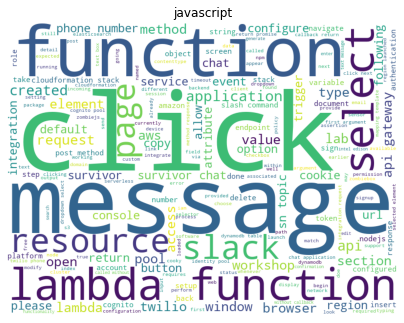

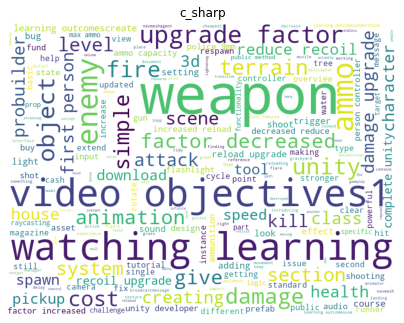

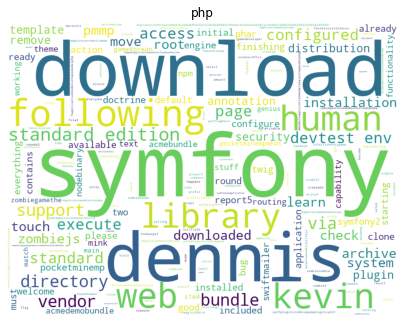

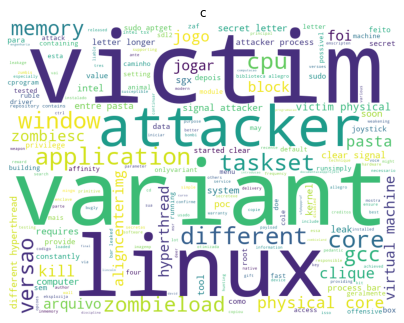

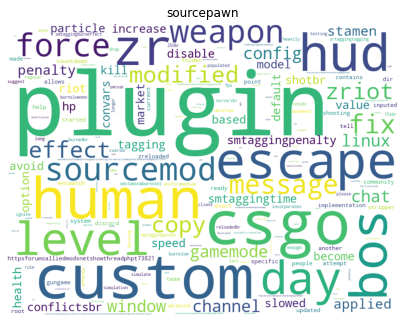

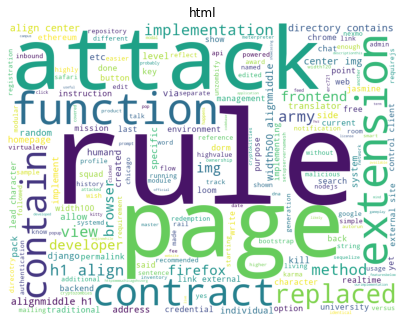

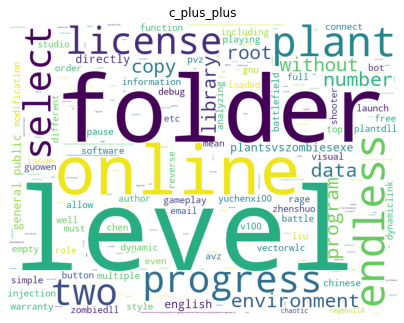

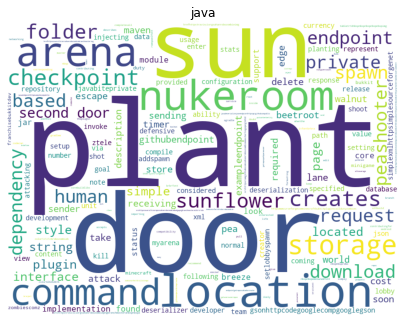

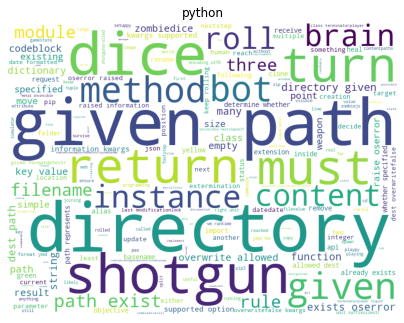

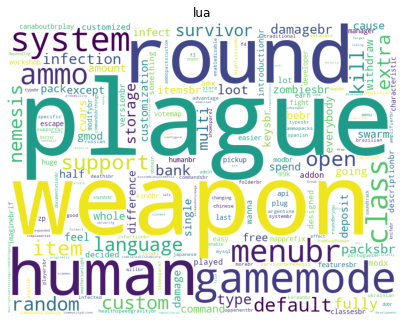

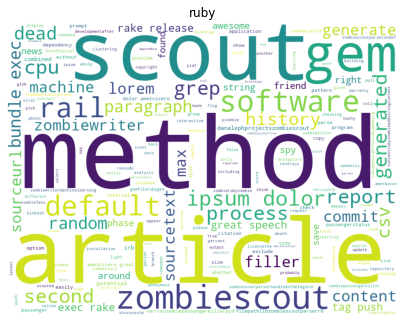

In [90]:
# word clouds
for language in word_lists:
    plt.figure(figsize=(7,7))
    img = WordCloud(background_color='white', width=800, height=600).generate(word_lists[language])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{language}')

### Bigrams

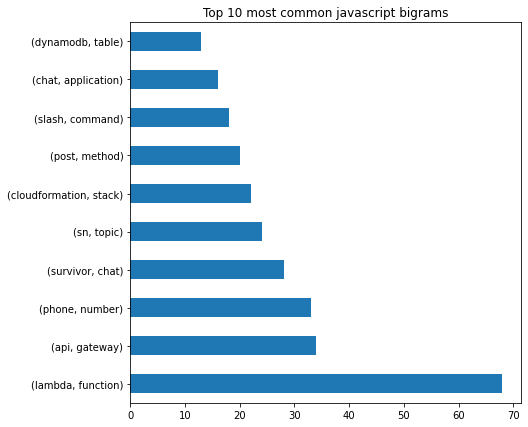

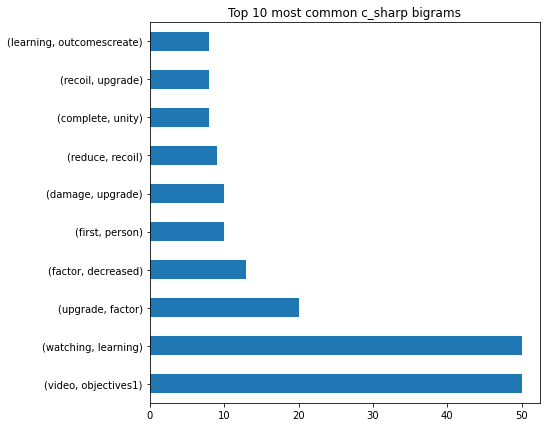

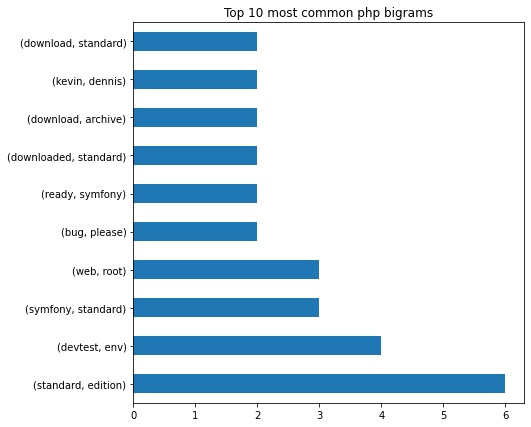

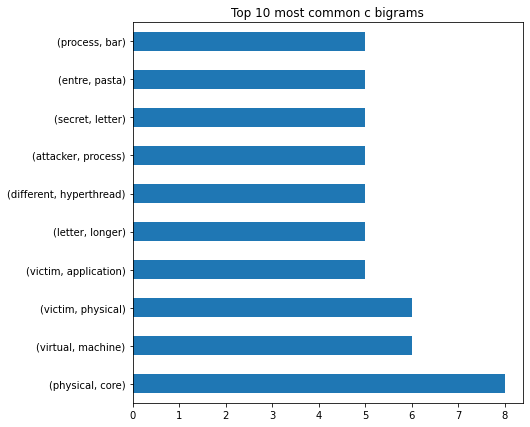

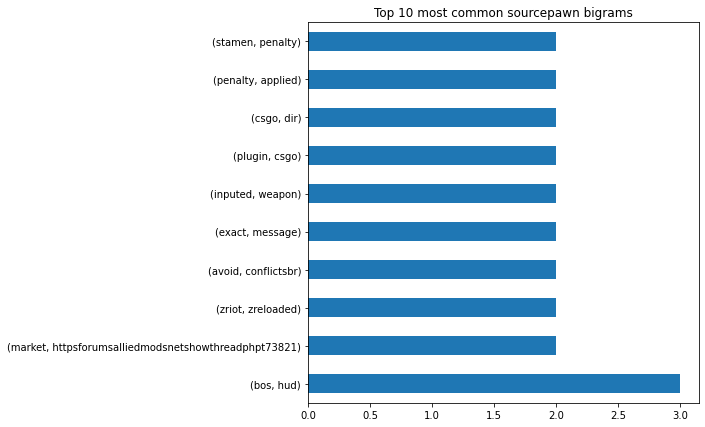

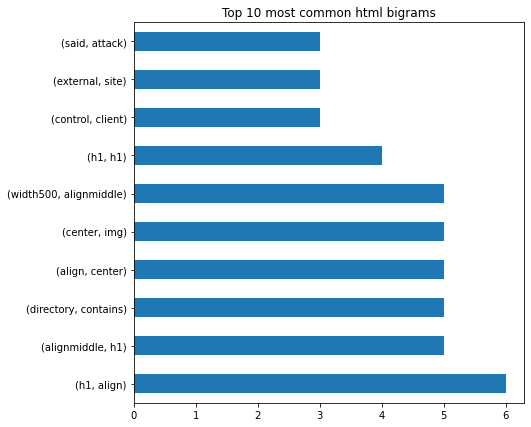

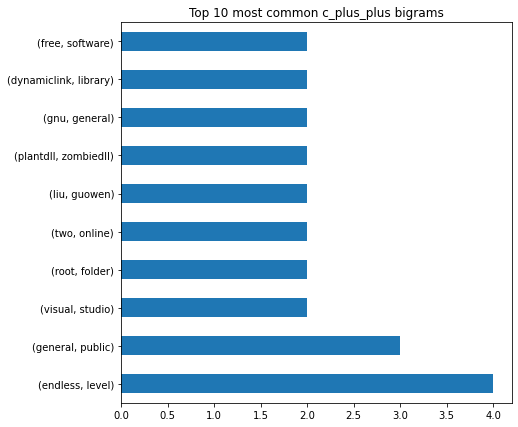

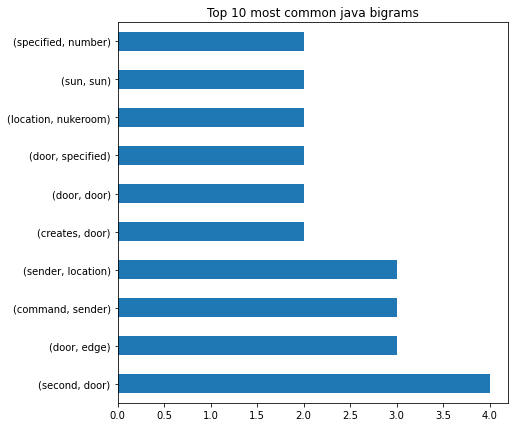

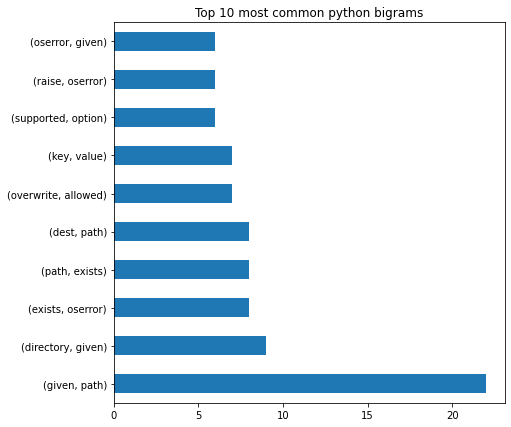

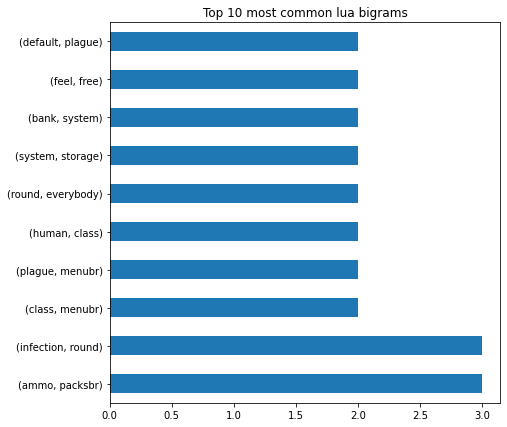

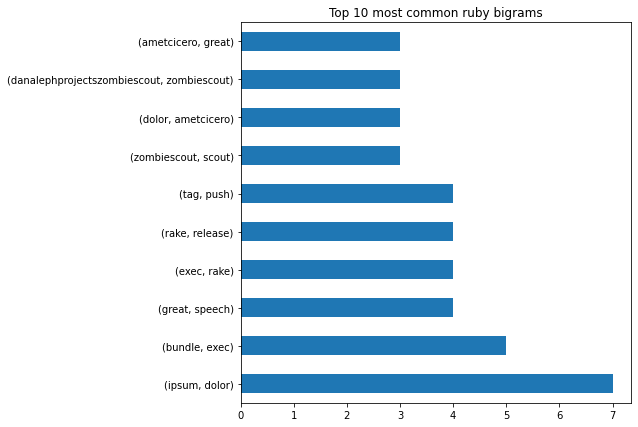

In [91]:
for language in word_lists:
    plt.figure(figsize=(7,7))
    pd.Series(nltk.bigrams(word_lists[language].split())).value_counts().head(10).plot.barh()
    plt.title(f'Top 10 most common {language} bigrams')

### Trigrams

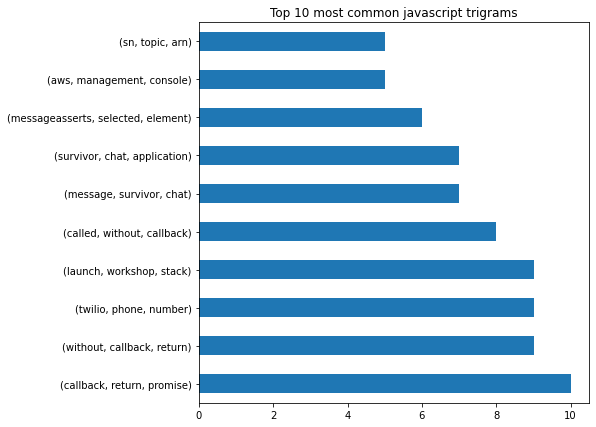

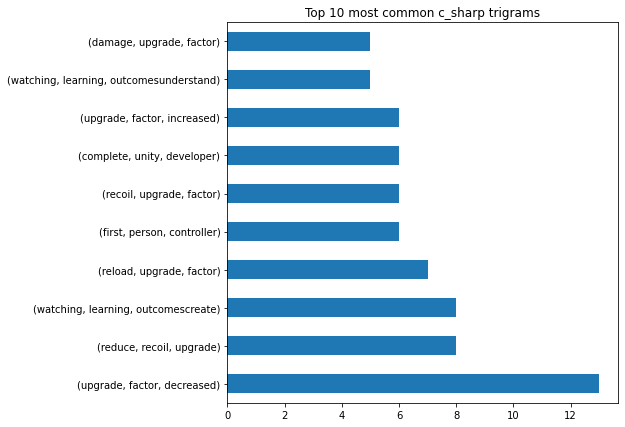

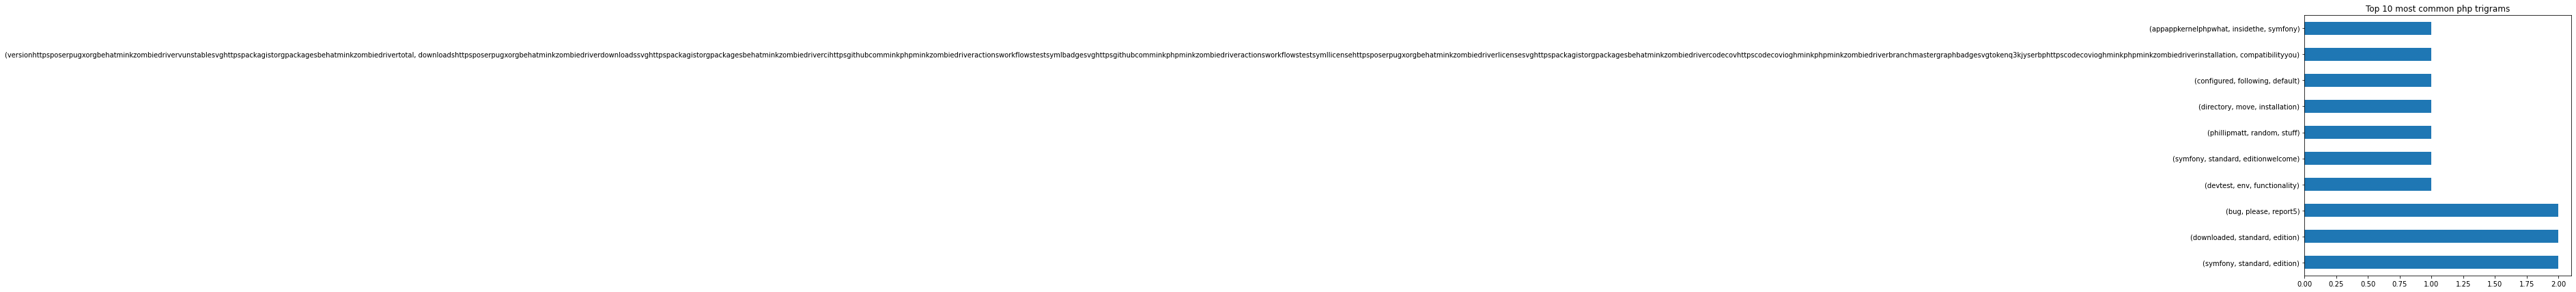

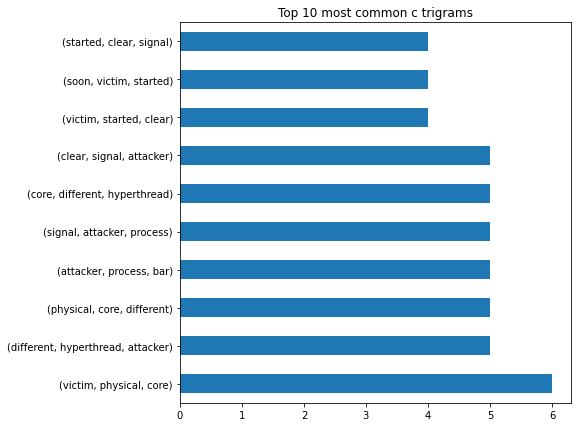

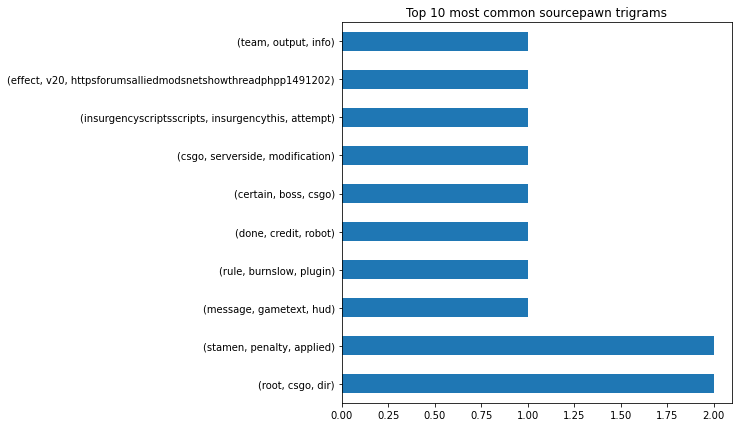

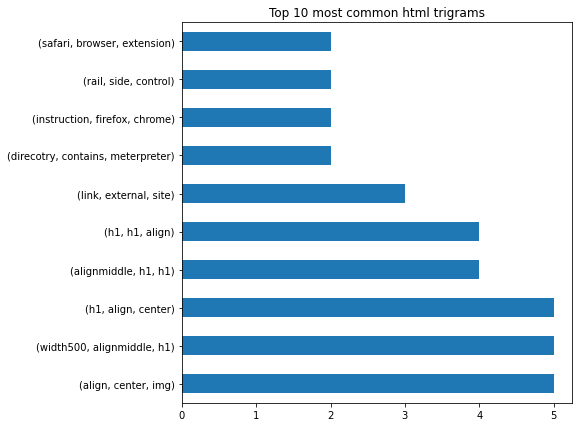

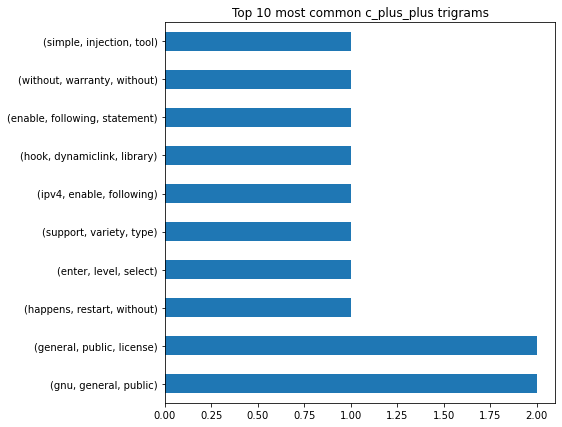

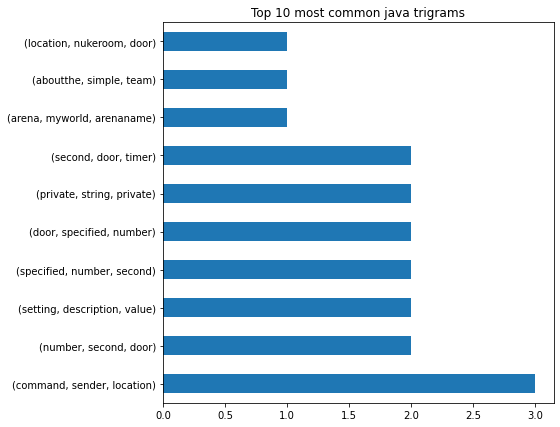

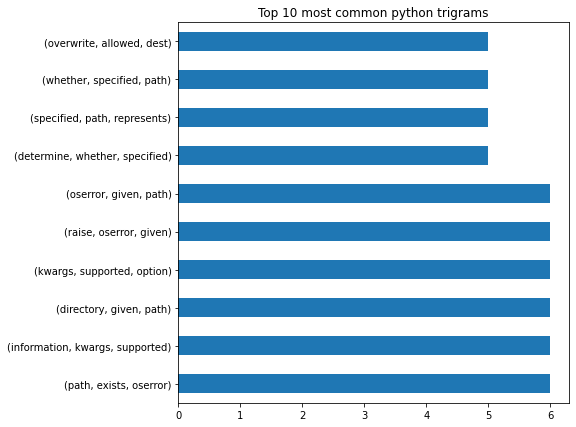

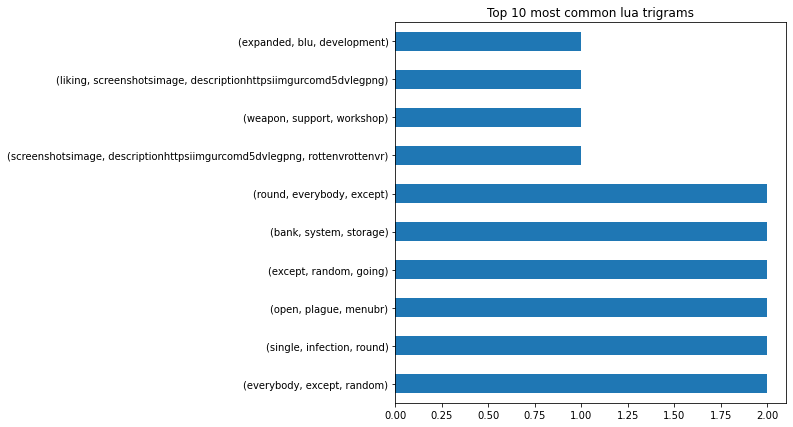

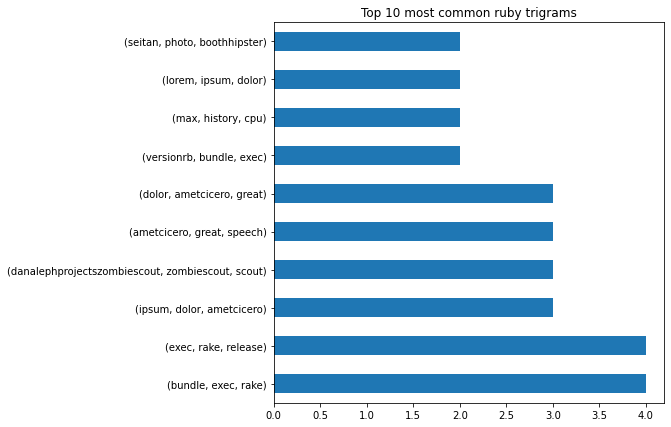

In [92]:
for language in word_lists:
    plt.figure(figsize=(7,7))
    pd.Series(nltk.trigrams(word_lists[language].split())).value_counts().head(10).plot.barh()
    plt.title(f'Top 10 most common {language} trigrams')

### Word Count and Message Length

In [93]:
train['message_length'] = train.lemmatized.apply(len)
train['word_count'] = train.lemmatized.apply(basic_clean).apply(str.split).apply(len)

validate['message_length'] = validate.lemmatized.apply(len)
validate['word_count'] = validate.lemmatized.apply(basic_clean).apply(str.split).apply(len)

test['message_length'] = test.lemmatized.apply(len)
test['word_count'] = test.lemmatized.apply(basic_clean).apply(str.split).apply(len)

train.head()

,repo,language,readme_contents,link,clean,stemmed,lemmatized,message_length,word_count
219,hugo451/zombiesland,C,# ZombieLand - Documentação\n<p>Projeto final ...,https://github.com/hugo451/zombiesland,zombieland documentacaopprojeto final discipli...,zombieland documentacaopprojeto final discipli...,zombieland documentacaopprojeto final discipli...,3558,378
145,kz26/uchicago-hvz,HTML,# University of Chicago Humans versus Zombies\...,https://github.com/kz26/uchicago-hvz,university chicago humans versus zombies descr...,univers chicago human versu zombi descriptiont...,university chicago human versus descriptionthi...,2548,286
76,dmcinnes/dead-valley,JavaScript,Dead Valley\n===========\n\nEscape from Zombie...,https://github.com/dmcinnes/dead-valley,dead valleyescape zombieinfested dead valley h...,dead valleyescap zombieinfest dead valley thi ...,dead valleyescape zombieinfested dead valley h...,1548,139
111,TheJosh/chaotic-rage,C++,Chaotic Rage\n============\n\n[![Build Status]...,https://github.com/TheJosh/chaotic-rage,chaotic ragebuild statushttpstravisciorgthejos...,chaotic ragebuild statushttpstravisciorgthejos...,chaotic ragebuild statushttpstravisciorgthejos...,1632,164
87,CSCI-E32/zombietranslator,HTML,*The end is nigh!*\nBut we can prepare. In thi...,https://github.com/CSCI-E32/zombietranslator,nighbut prepare assignment begin preparing cre...,nighbut prepar thi assign begin prepar creat s...,nighbut prepare assignment begin preparing cre...,1608,175


In [94]:
import nltk.sentiment
sia = nltk.sentiment.SentimentIntensityAnalyzer()
sia.polarity_scores(all_words)

{'neg': 0.073, 'neu': 0.81, 'pos': 0.117, 'compound': 1.0}

In [95]:
# train['sentiment'] = train.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])
# validate['sentiment'] = validate.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])
# test['sentiment'] = test.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])

# train

In [96]:
# train.groupby('language').sentiment.agg(['mean','median'])

In [97]:
# #plot message_length vs sentiment and hue by label
# sns.relplot(data = train, x = 'word_count', y = 'sentiment')

## IDF ---- Copied to above
### Using IDF to identify words to exclude from modeling?
- Can high scoring words lead to overfitting?
- Low scoring words can be removed to reduce clutter


In [98]:
# repos = [repo for repo in train.lemmatized]

In [99]:
# def idf(word):
#     '''A simple way to calculate idf for demonstration. Note that this 
#     function relies on a globally defined blogs variable.'''
#     n_occurences = sum([1 for doc in repos if word in doc])
#     return len(repos) / n_occurences

In [100]:
# unique_words = pd.Series(' '.join(repos).split()).unique()
# unique_words

In [101]:
# # put the unique words into a data frame
# words_idf = (pd.DataFrame(dict(word=unique_words))
#  # calculate the idf for each word
#  .assign(idf=lambda train: train.word.apply(idf))
#  # sort the data for presentation purposes
#  .set_index('word')
#  .sort_values(by='idf', ascending=False))

In [102]:
# words_idf.describe()

In [103]:
# words_idf[(words_idf.idf <= 50) & (words_idf.idf >= 10)].idf.value_counts()

In [104]:
# words_idf[(words_idf.idf > 50) | (words_idf.idf <= 10)].index.to_list()

In [105]:
# more_stopwords = words_idf[(words_idf.idf > 50) | (words_idf.idf <= 10)].index.to_list()

Remove more stopwords!

In [106]:
# # loop through each column in train
# for col in train.columns.to_list():
#     # loop through rows in column
#     for content in col:
#         # replace content with additional removed stopwords
#         content = remove_stopwords(content, more_stopwords)

# # repeat for validate and test
# ##### More stopwords was retrieved from the test dataset so no data leakage occurs with this transformation
# for col in validate.columns.to_list():
#     # loop through rows in column
#     for content in col:
#         # replace content with additional removed stopwords
#         content = remove_stopwords(content, more_stopwords)

# for col in test.columns.to_list():
#     # loop through rows in column
#     for content in col:
#         # replace content with additional removed stopwords
#         content = remove_stopwords(content, more_stopwords)


In [107]:
# train

## TFIDF

In [108]:
# redefine repos
repos = [repo for repo in train.lemmatized]

# create tfidf object
tfidf = TfidfVectorizer()

# fit/use tfidf
#train
tfidfs = tfidf.fit_transform(repos)

#validate
validate_tfidf = tfidf.transform([repo for repo in validate.lemmatized])

#test
test_tfidf = tfidf.transform([repo for repo in test.lemmatized])

In [109]:
tfidf_df = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
validate_tfidf_df = pd.DataFrame(validate_tfidf.todense(), columns=tfidf.get_feature_names())
test_tfidf_df = pd.DataFrame(test_tfidf.todense(), columns=tfidf.get_feature_names())

In [110]:
tfidf_df

,0005,001,003,0041942649,005,006,00zombiescout,010,010x,015,...,zriothuman,zriotrestrict,zriotsetday,zriotunrestrict,zriotzombie,zrtaggingtagging,zssfollow,ztele,zumbis,zurb
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063845,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054998,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [111]:
train = pd.merge(train,tfidf_df,how='left',right_index=True, left_index=True).fillna(0.0).rename(columns={'language_x':'coding_language', 'clean_x':'cleaned_readme', 'link_x':'repo_link'})
train.head()

validate = pd.merge(validate,tfidf_df,how='left',right_index=True, left_index=True).fillna(0.0).rename(columns={'language_x':'coding_language', 'clean_x':'cleaned_readme', 'link_x':'repo_link'})
test = pd.merge(test,tfidf_df,how='left',right_index=True, left_index=True).fillna(0.0).rename(columns={'language_x':'coding_language', 'clean_x':'cleaned_readme', 'link_x':'repo_link'})


## Statistics

Most Common Words in All Readmes

In [112]:
# all words top frequency
word_counts.sort_values('all', ascending = False).head(20)

,javascript,c_sharp,php,c,sourcepawn,html,c_plus_plus,java,python,lua,ruby,all
function,137,0,0,0,0,8,2,1,8,0,0,156
click,119,2,1,0,0,2,0,0,0,0,0,124
method,71,8,0,0,0,6,0,0,12,0,20,117
lambda,111,0,0,0,0,0,0,0,0,0,0,111
message,95,5,0,0,4,1,0,0,1,0,0,106
api,87,1,0,0,1,2,0,0,5,1,0,97
page,70,2,4,1,0,10,0,3,1,0,0,91
chat,76,3,0,1,3,3,0,0,0,1,0,87
application,68,0,2,10,0,1,0,0,2,0,3,86
request,71,0,0,0,0,1,1,4,5,0,2,84


### Average lengths of README by programming language

In [113]:
# average character count by language

train.groupby('coding_language').message_length.mean()

coding_language
C             1097.909091
C#            2063.583333
C++            938.000000
HTML           905.545455
Java          1151.428571
JavaScript    7477.583333
Lua            551.333333
PHP            707.818182
Python        3819.000000
Ruby          2142.666667
SourcePawn     544.181818
Name: message_length, dtype: float64

In [114]:
# average word count by language

train.groupby('coding_language').word_count.mean().index.to_list()

['C',
 'C#',
 'C++',
 'HTML',
 'Java',
 'JavaScript',
 'Lua',
 'PHP',
 'Python',
 'Ruby',
 'SourcePawn']

### Unique words by programming language

In [115]:
# unique words per language?
for language in word_counts.columns.to_list():
    print(language)
    print(pd.DataFrame(word_counts.sort_values(language, ascending = False).head(20)))
    print('\n\n\n')

javascript
             javascript  c_sharp  php   c  sourcepawn  html  c_plus_plus  \
function            137        0    0   0           0     8            2   
click               119        2    1   0           0     2            0   
lambda              111        0    0   0           0     0            0   
message              95        5    0   0           4     1            0   
api                  87        1    0   0           1     2            0   
chat                 76        3    0   1           3     3            0   
select               72        3    1   0           0     0            4   
request              71        0    0   0           0     1            1   
method               71        8    0   0           0     6            0   
page                 70        2    4   1           0    10            0   
resource             68        3    0   0           0     0            0   
application          68        0    2  10           0     1            0   
b

### IDF Distributions

In [116]:
dist_loop = word_counts.sort_values('all', ascending = False).head(20).index.to_list()

In [117]:
train

,repo,coding_language,readme_contents,repo_link,cleaned_readme,stemmed,lemmatized,message_length,word_count,0005,...,zriothuman,zriotrestrict,zriotsetday,zriotunrestrict,zriotzombie,zrtaggingtagging,zssfollow,ztele,zumbis,zurb
219,hugo451/zombiesland,C,# ZombieLand - Documentação\n<p>Projeto final ...,https://github.com/hugo451/zombiesland,zombieland documentacaopprojeto final discipli...,zombieland documentacaopprojeto final discipli...,zombieland documentacaopprojeto final discipli...,3558,378,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,kz26/uchicago-hvz,HTML,# University of Chicago Humans versus Zombies\...,https://github.com/kz26/uchicago-hvz,university chicago humans versus zombies descr...,univers chicago human versu zombi descriptiont...,university chicago human versus descriptionthi...,2548,286,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,dmcinnes/dead-valley,JavaScript,Dead Valley\n===========\n\nEscape from Zombie...,https://github.com/dmcinnes/dead-valley,dead valleyescape zombieinfested dead valley h...,dead valleyescap zombieinfest dead valley thi ...,dead valleyescape zombieinfested dead valley h...,1548,139,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,TheJosh/chaotic-rage,C++,Chaotic Rage\n============\n\n[![Build Status]...,https://github.com/TheJosh/chaotic-rage,chaotic ragebuild statushttpstravisciorgthejos...,chaotic ragebuild statushttpstravisciorgthejos...,chaotic ragebuild statushttpstravisciorgthejos...,1632,164,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,CSCI-E32/zombietranslator,HTML,*The end is nigh!*\nBut we can prepare. In thi...,https://github.com/CSCI-E32/zombietranslator,nighbut prepare assignment begin preparing cre...,nighbut prepar thi assign begin prepar creat s...,nighbut prepare assignment begin preparing cre...,1608,175,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,minkphp/MinkZombieDriver,PHP,Mink Zombie.js Driver\n=====================\n...,https://github.com/minkphp/MinkZombieDriver,mink zombiejs driverlatest stable versionhttps...,mink zombiej driverlatest stabl versionhttpspo...,mink zombiejs driverlatest stable versionhttps...,1489,63,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,dsnezhkov/zombieant,C,# Zombie Ant Farm: A Kit For Playing Hide and ...,https://github.com/dsnezhkov/zombieant,farm kit playing hide seek linux edrsversion 0...,zombi farm kit hide seek linux edrsvers 05alph...,farm kit playing hide seek linux edrsversion 0...,862,97,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,CompleteUnityDeveloper2/6_Zombie_Runner,C#,# 06-Zombie-Runner\nIn this section we create ...,https://github.com/CompleteUnityDeveloper2/6_Z...,06zombierunnerin section first person shooter ...,06zombierunnerin thi section creat first perso...,06zombierunnerin section first person shooter ...,9905,1219,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,mileskin/zombie-jasmine-spike,JavaScript,Spike project for trying out [Zombie.js](http:...,https://github.com/mileskin/zombie-jasmine-spike,spike trying zombiejshttpzombielabnotesorg jas...,spike tri zombiejshttpzombielabnotesorg jasmin...,spike trying zombiejshttpzombielabnotesorg jas...,1034,87,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


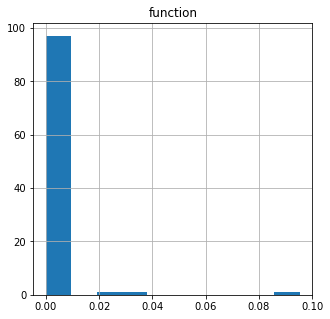

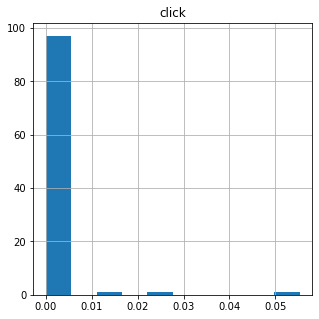

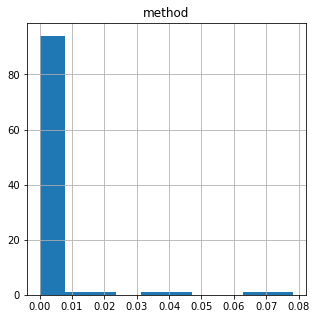

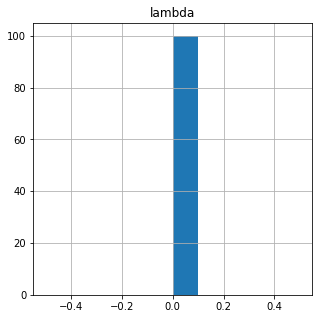

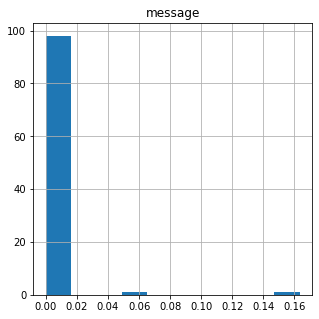

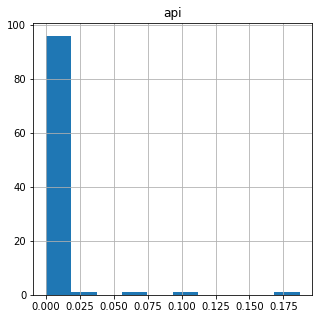

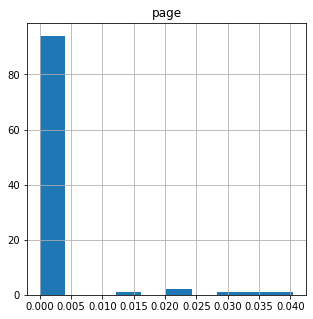

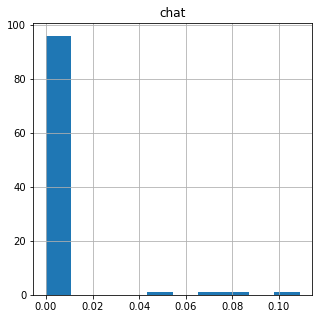

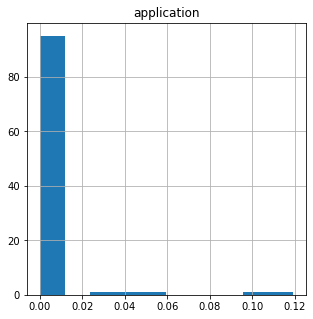

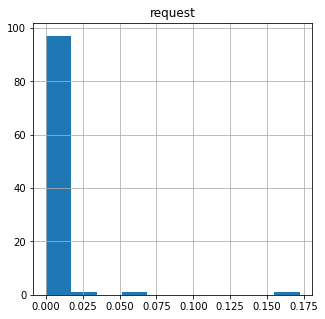

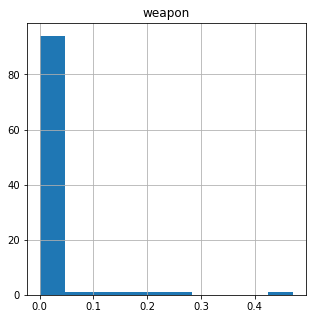

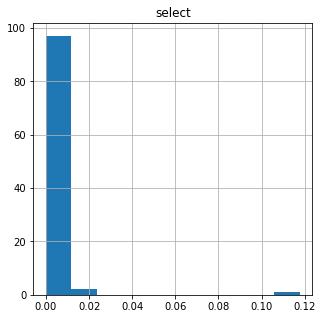

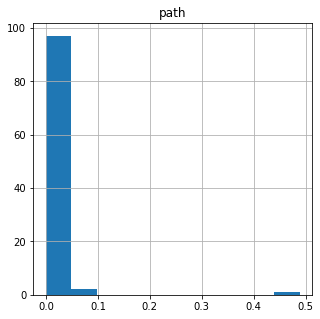

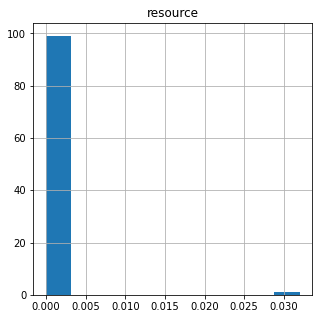

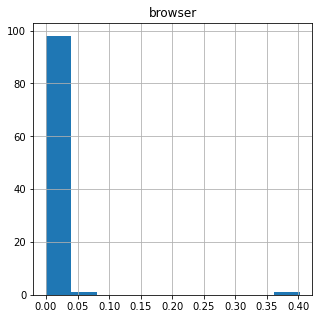

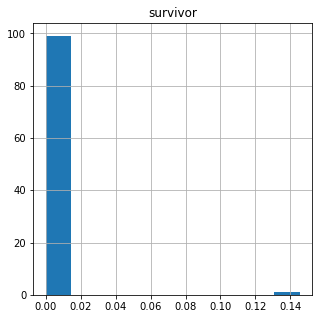

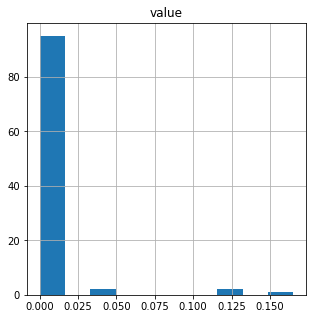

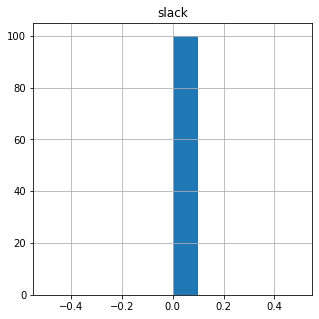

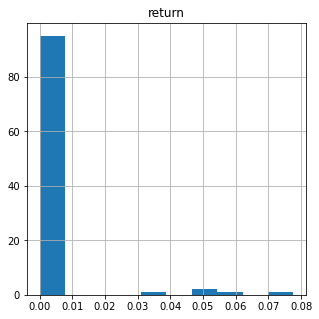

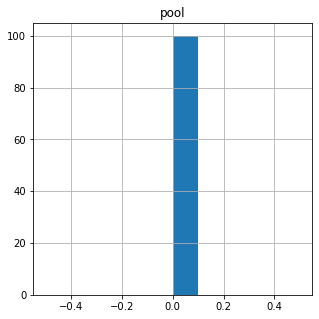

In [118]:
# tfidf top word distributions
for word in dist_loop:
    plt.figure(figsize=(5,5))
    train[word].hist()
    plt.title(word)

## Modeling

In [119]:
train

,repo,coding_language,readme_contents,repo_link,cleaned_readme,stemmed,lemmatized,message_length,word_count,0005,...,zriothuman,zriotrestrict,zriotsetday,zriotunrestrict,zriotzombie,zrtaggingtagging,zssfollow,ztele,zumbis,zurb
219,hugo451/zombiesland,C,# ZombieLand - Documentação\n<p>Projeto final ...,https://github.com/hugo451/zombiesland,zombieland documentacaopprojeto final discipli...,zombieland documentacaopprojeto final discipli...,zombieland documentacaopprojeto final discipli...,3558,378,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,kz26/uchicago-hvz,HTML,# University of Chicago Humans versus Zombies\...,https://github.com/kz26/uchicago-hvz,university chicago humans versus zombies descr...,univers chicago human versu zombi descriptiont...,university chicago human versus descriptionthi...,2548,286,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,dmcinnes/dead-valley,JavaScript,Dead Valley\n===========\n\nEscape from Zombie...,https://github.com/dmcinnes/dead-valley,dead valleyescape zombieinfested dead valley h...,dead valleyescap zombieinfest dead valley thi ...,dead valleyescape zombieinfested dead valley h...,1548,139,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,TheJosh/chaotic-rage,C++,Chaotic Rage\n============\n\n[![Build Status]...,https://github.com/TheJosh/chaotic-rage,chaotic ragebuild statushttpstravisciorgthejos...,chaotic ragebuild statushttpstravisciorgthejos...,chaotic ragebuild statushttpstravisciorgthejos...,1632,164,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,CSCI-E32/zombietranslator,HTML,*The end is nigh!*\nBut we can prepare. In thi...,https://github.com/CSCI-E32/zombietranslator,nighbut prepare assignment begin preparing cre...,nighbut prepar thi assign begin prepar creat s...,nighbut prepare assignment begin preparing cre...,1608,175,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,minkphp/MinkZombieDriver,PHP,Mink Zombie.js Driver\n=====================\n...,https://github.com/minkphp/MinkZombieDriver,mink zombiejs driverlatest stable versionhttps...,mink zombiej driverlatest stabl versionhttpspo...,mink zombiejs driverlatest stable versionhttps...,1489,63,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,dsnezhkov/zombieant,C,# Zombie Ant Farm: A Kit For Playing Hide and ...,https://github.com/dsnezhkov/zombieant,farm kit playing hide seek linux edrsversion 0...,zombi farm kit hide seek linux edrsvers 05alph...,farm kit playing hide seek linux edrsversion 0...,862,97,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,CompleteUnityDeveloper2/6_Zombie_Runner,C#,# 06-Zombie-Runner\nIn this section we create ...,https://github.com/CompleteUnityDeveloper2/6_Z...,06zombierunnerin section first person shooter ...,06zombierunnerin thi section creat first perso...,06zombierunnerin section first person shooter ...,9905,1219,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,mileskin/zombie-jasmine-spike,JavaScript,Spike project for trying out [Zombie.js](http:...,https://github.com/mileskin/zombie-jasmine-spike,spike trying zombiejshttpzombielabnotesorg jas...,spike tri zombiejshttpzombielabnotesorg jasmin...,spike trying zombiejshttpzombielabnotesorg jas...,1034,87,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
# create list of features for modeling
features = train.drop(columns = ['repo','coding_language','readme_contents','repo_link','cleaned_readme','stemmed','lemmatized']).columns.to_list()

In [121]:
# Create X and y for train, validate, test

X_train =  train[features]
y_train =  train.coding_language
X_validate = validate[features]
y_validate = validate.coding_language
X_test = test[features]
y_test = test.coding_language

In [122]:
# train['coding_language_encoded'] = train.coding_language.map({'C':0,
#  'C#':1,
#  'C++':2,
#  'HTML':3,
#  'Java':4,
#  'JavaScript':5,
#  'Lua':6,
#  'PHP':7,
#  'Python':8,
#  'Ruby':9,
#  'SourcePawn':10})

In [128]:
lm = LogisticRegression().fit(X_train, y_train)

train['predicted_lm']= lm.predict(X_train)


In [124]:
train.head()

,repo,coding_language,readme_contents,repo_link,cleaned_readme,stemmed,lemmatized,message_length,word_count,0005,...,zriotrestrict,zriotsetday,zriotunrestrict,zriotzombie,zrtaggingtagging,zssfollow,ztele,zumbis,zurb,predicted
219,hugo451/zombiesland,C,# ZombieLand - Documentação\n<p>Projeto final ...,https://github.com/hugo451/zombiesland,zombieland documentacaopprojeto final discipli...,zombieland documentacaopprojeto final discipli...,zombieland documentacaopprojeto final discipli...,3558,378,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JavaScript
145,kz26/uchicago-hvz,HTML,# University of Chicago Humans versus Zombies\...,https://github.com/kz26/uchicago-hvz,university chicago humans versus zombies descr...,univers chicago human versu zombi descriptiont...,university chicago human versus descriptionthi...,2548,286,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JavaScript
76,dmcinnes/dead-valley,JavaScript,Dead Valley\n===========\n\nEscape from Zombie...,https://github.com/dmcinnes/dead-valley,dead valleyescape zombieinfested dead valley h...,dead valleyescap zombieinfest dead valley thi ...,dead valleyescape zombieinfested dead valley h...,1548,139,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JavaScript
111,TheJosh/chaotic-rage,C++,Chaotic Rage\n============\n\n[![Build Status]...,https://github.com/TheJosh/chaotic-rage,chaotic ragebuild statushttpstravisciorgthejos...,chaotic ragebuild statushttpstravisciorgthejos...,chaotic ragebuild statushttpstravisciorgthejos...,1632,164,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JavaScript
87,CSCI-E32/zombietranslator,HTML,*The end is nigh!*\nBut we can prepare. In thi...,https://github.com/CSCI-E32/zombietranslator,nighbut prepare assignment begin preparing cre...,nighbut prepar thi assign begin prepar creat s...,nighbut prepare assignment begin preparing cre...,1608,175,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,JavaScript


In [125]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.coding_language, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.coding_language))
print('---')
print(classification_report(train.coding_language, train.predicted))

Accuracy: 23.00%
---
Confusion Matrix
coding_language  C  C#  C++  HTML  Java  JavaScript  Lua  PHP  Python  Ruby  \
predicted                                                                     
C#               3   6    0     1     1           1    2    1       1     1   
C++              1   0    1     0     0           0    0    0       0     0   
JavaScript       6   2    4     6     3           9    3    6       3     5   
PHP              1   2    2     1     1           1    0    3       0     0   
Python           0   0    0     0     0           1    0    0       2     0   
SourcePawn       0   2    0     3     2           0    1    1       0     0   

coding_language  SourcePawn  
predicted                    
C#                        0  
C++                       1  
JavaScript                6  
PHP                       2  
Python                    0  
SourcePawn                2  
---
              precision    recall  f1-score   support

           C       0.00      0

In [138]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 5, random_state = 222)
clf = clf.fit(X_train, y_train)
train['predicted_clf'] = clf.predict(X_train)

validate['predicted_clf'] = clf.predict(X_validate)

In [139]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.coding_language, train.predicted_clf)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted_clf, train.coding_language))
print('---')
print(classification_report(train.coding_language, train.predicted_clf))

print('Accuracy: {:.2%}'.format(accuracy_score(validate.coding_language, validate.predicted_clf)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(validate.predicted_clf, validate.coding_language))
print('---')
print(classification_report(validate.coding_language, validate.predicted_clf))

Accuracy: 31.00%
---
Confusion Matrix
coding_language  C  C#  C++  HTML  Java  JavaScript  Lua  PHP  Python  Ruby  \
predicted_clf                                                                 
C                9   5    2     7     2           2    3    9       2     0   
C#               0   1    0     0     0           0    0    0       1     0   
C++              0   0    4     0     0           0    0    0       0     0   
Java             0   0    0     0     3           0    0    0       0     0   
JavaScript       2   6    1     4     2          10    1    2       3     4   
Lua              0   0    0     0     0           0    2    0       0     0   
Ruby             0   0    0     0     0           0    0    0       0     2   

coding_language  SourcePawn  
predicted_clf                
C                         8  
C#                        0  
C++                       0  
Java                      0  
JavaScript                3  
Lua                       0  
Ruby      

In [135]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(min_samples_leaf=3,criterion='gini',max_depth=5,random_state=222)

rf.fit(X_train, y_train)
train['predicted_rf'] = rf.predict(X_train)

In [136]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.coding_language, train.predicted_rf)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted_clf, train.coding_language))
print('---')
print(classification_report(train.coding_language, train.predicted_rf))

Accuracy: 28.00%
---
Confusion Matrix
coding_language  C  C#  C++  HTML  Java  JavaScript  Lua  PHP  Python  Ruby  \
predicted_clf                                                                 
C                9   5    2     7     2           2    3    9       2     0   
C#               0   1    0     0     0           0    0    0       1     0   
C++              0   0    4     0     0           0    0    0       0     0   
Java             0   0    0     0     3           0    0    0       0     0   
JavaScript       2   6    1     4     2          10    1    2       3     4   
Lua              0   0    0     0     0           0    2    0       0     0   
Ruby             0   0    0     0     0           0    0    0       0     2   

coding_language  SourcePawn  
predicted_clf                
C                         8  
C#                        0  
C++                       0  
Java                      0  
JavaScript                3  
Lua                       0  
Ruby      

In [140]:
def tree_train_validate(X_train, y_train, X_validate, y_validate, tree_model, min_samples_leaf):

    '''
    This function takes in train, validate and test modeling sets, a decision tree or random forest classifier model, and a specified minimum number of samples
    per leaf, and prints out train and validate accuracy results for 10 different depths and plots the validate accuracy results for different depths.
    '''

    depth_range = range(1, 11)    # set a range of depths to explore

    scores = []    # set an empty list for validate scores

    metrics = []    # set an empty list for dictionaries

    for depth in depth_range:    # commence loop through different max depths for Decision Tree

        model = tree_model(max_depth = depth, min_samples_leaf = min_samples_leaf, random_state = 421) # create object

        model.fit(X_train, y_train)    # fit object

        scores.append(model.score(X_validate, y_validate))    # add validate scores to scores list

        in_sample_accuracy = model.score(X_train, y_train)    # calculate accuracy on train set

        out_of_sample_accuracy = model.score(X_validate, y_validate)    # calculate accuracy on validate set

        output = {                                       # create dictionary with max_depth,
            'max_depth': depth,                          # train set accuracy, and validate accuracy
            'train_accuracy': in_sample_accuracy,        
            'validate_accuracy': out_of_sample_accuracy
        }

        metrics.append(output)    # add dictionaries to list

    plt.figure()    # create figure

    plt.xlabel('depth')    # label x-axis

    plt.ylabel('accuracy')    # label y-axis

    plt.scatter(depth_range, scores, color = 'indianred') # plot relatiosnhip between depth range and validate accuracy

    plt.xticks([0, 2, 4, 6, 8, 10])    # customize x-axis label ticks

    plt.title('Validate Accuracy')    # title

    plt.show();     # show

    metrics_df = pd.DataFrame(metrics)    # form dataframe from scores data

    metrics_df = metrics_df.set_index('max_depth')   # set index to max depth

    metrics_df['difference'] = metrics_df.train_accuracy - metrics_df.validate_accuracy   # create column of values
                                                                        # for difference between train and validate
    print(metrics_df)         # view metrics dataframe


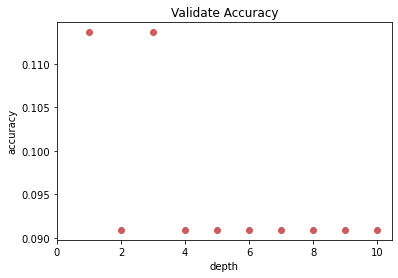

           train_accuracy  validate_accuracy  difference
max_depth                                               
1                    0.25           0.113636    0.136364
2                    0.28           0.090909    0.189091
3                    0.30           0.113636    0.186364
4                    0.32           0.090909    0.229091
5                    0.30           0.090909    0.209091
6                    0.32           0.090909    0.229091
7                    0.32           0.090909    0.229091
8                    0.32           0.090909    0.229091
9                    0.32           0.090909    0.229091
10                   0.32           0.090909    0.229091


In [143]:
tree_train_validate(X_train,y_train,X_validate,y_validate,tree_model=RandomForestClassifier, min_samples_leaf = 3)